# **TSIA206 - LAB 1 - QUENIAT HUGO**

# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

In [18]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write
import scipy.signal as signal

## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return x_

def period(x, Fs, Pmin=1/300, Pmax=1/80, seuil=0.7) :
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.floor(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax,N])

    Nfft = nextpow2(2*N-1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/(N-P))
    voiced = corr > seuil
    if not(voiced):
        P = np.round(10e-3*Fs)

    return P,voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [5]:
IPython.display.Audio('aeiou.wav')

In [6]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [7]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

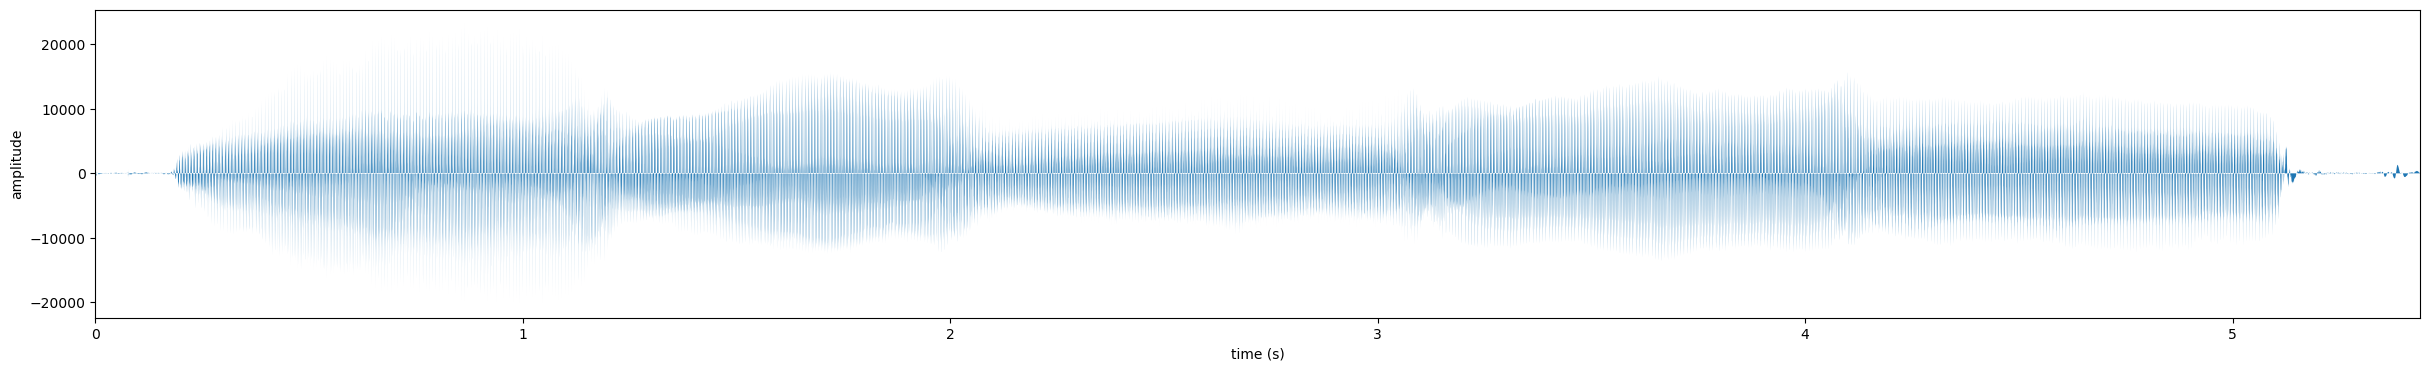

In [7]:
plot_sound(x, times)

In [9]:
write('new_aeiou.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

## 1 Extraction of the analysis marks

In [8]:
P, voiced = period(x, Fs)

In [246]:
def AnalysisPitchMarks(s,Fs):
    
    # Initialization of the variables
    t_a = np.zeros(1)
    P_a = np.asarray([int(0.01 * Fs)])
    voiced = np.zeros(1)
    
    # Computation of the analysis marks
    while (t_a[-1] + 2.5 * P_a[-1] < len(s)):
        
        # Extraction of the sequence 
        x_extracted = s[int(t_a[-1]):int(t_a[-1] + 2.5 * P_a[-1])]
        
        # Computation of P_a and voiced
        newP_a, newvoiced = period(x_extracted, Fs)
        P_a = np.append(P_a, newP_a)
        voiced = np.append(voiced, newvoiced)
        
        # Computation of t_a
        t_a = np.append(t_a, t_a[-1] + P_a[-1])
        
    return np.array([t_a, voiced, P_a]).astype(int)
    
    
    

In [296]:
A = AnalysisPitchMarks(x, Fs)

## 2 Synthesis and modification of the temporal and spectral scales

In [297]:
B = np.array([A[0,:], np.arange(A.shape[1])])

### 2.1 Signal synthesis

In [356]:
def synthesis(s,Fs,A,B):
    
    # Initialization of the variables
    t_s = B[0]
    n = B[1]
    k_end = B.shape[1] -1
    t_a = A[0]
    P_a = A[2]
  
    y = np.zeros(t_s[k_end] + P_a[n[k_end]])
    
    for k in range(1, k_end+1):
        
        # Extraction of the sequence
        x_extracted = s[int(t_a[n[k]] - P_a[n[k]]):int(t_a[n[k]] +  P_a[n[k]])]
        
        # Windowing of the extracted sequence
        x_extracted = x_extracted * signal.windows.hann(len(x_extracted))

		# Overlap and add
        y[int(t_s[k] - P_a[n[k]]):int(t_s[k] +  P_a[n[k]])] += x_extracted
        
    return y
    
	

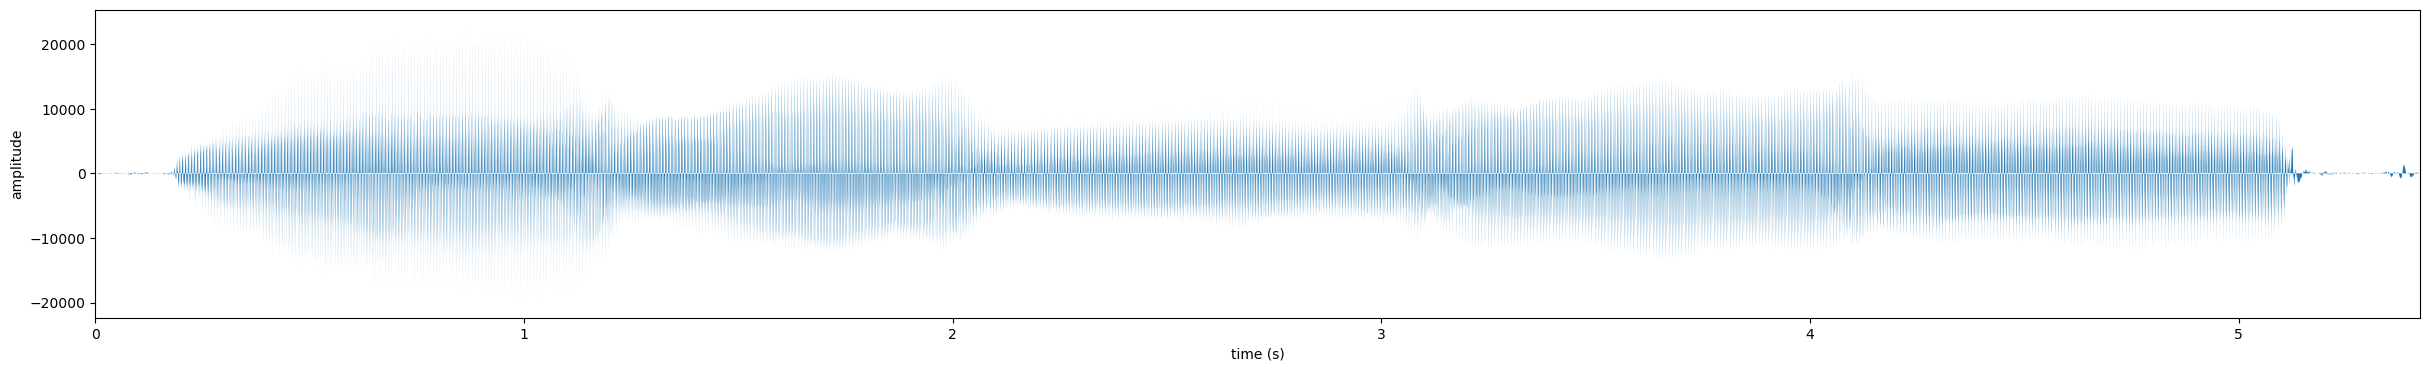

In [298]:
y = synthesis(x, Fs, A, B)

t = np.arange(len(y)) * timestep
plot_sound(y, t)
write('new_aeiou.wav', Fs, np.array(y, dtype=np.int16))


In [299]:
IPython.display.Audio('new_aeiou.wav')

**Observation** :

The reconstructed sound seems to be a perfect match to the orginal (at least my hears understand so).

### 2.2 Modification of the temporal scale

In [300]:
def changeTimeScale(alpha, A , Fs):
    
    # Initialization of the variables
    t_s = np.array([1])
    n = np.array([0,1])
    P_a = A[2]
    
    # While condition dictated by the length of the arrays involved
    while int(n[-1]) < len(P_a):
        
        t_s = np.append(t_s, t_s[-1] + P_a[int(n[-1])])
        n = np.append(n, n[-1] + 1/alpha)
    
    
    return np.array([t_s, n[:-1]]).astype(int)
    
    

In [357]:
alpha = 4

B = changeTimeScale(alpha, A, Fs)
y = synthesis(x, Fs, A, B)
t = np.arange(len(y)) * timestep


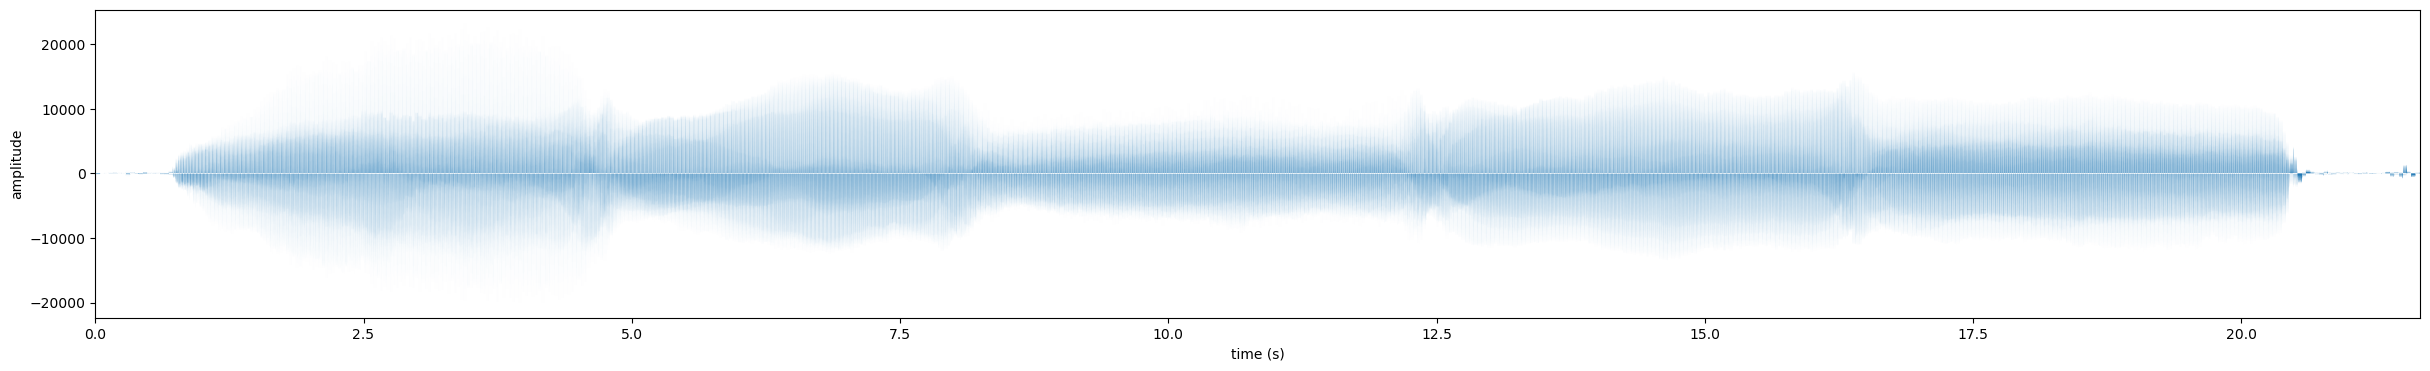

In [358]:
plot_sound(y, t)
write('new_aeiou.wav', Fs, np.array(y, dtype=np.int16))

In [359]:
IPython.display.Audio('new_aeiou.wav')

In [360]:
alpha = 0.25

B = changeTimeScale(alpha, A, Fs)
y = synthesis(x, Fs, A, B)
t = np.arange(len(y)) * timestep

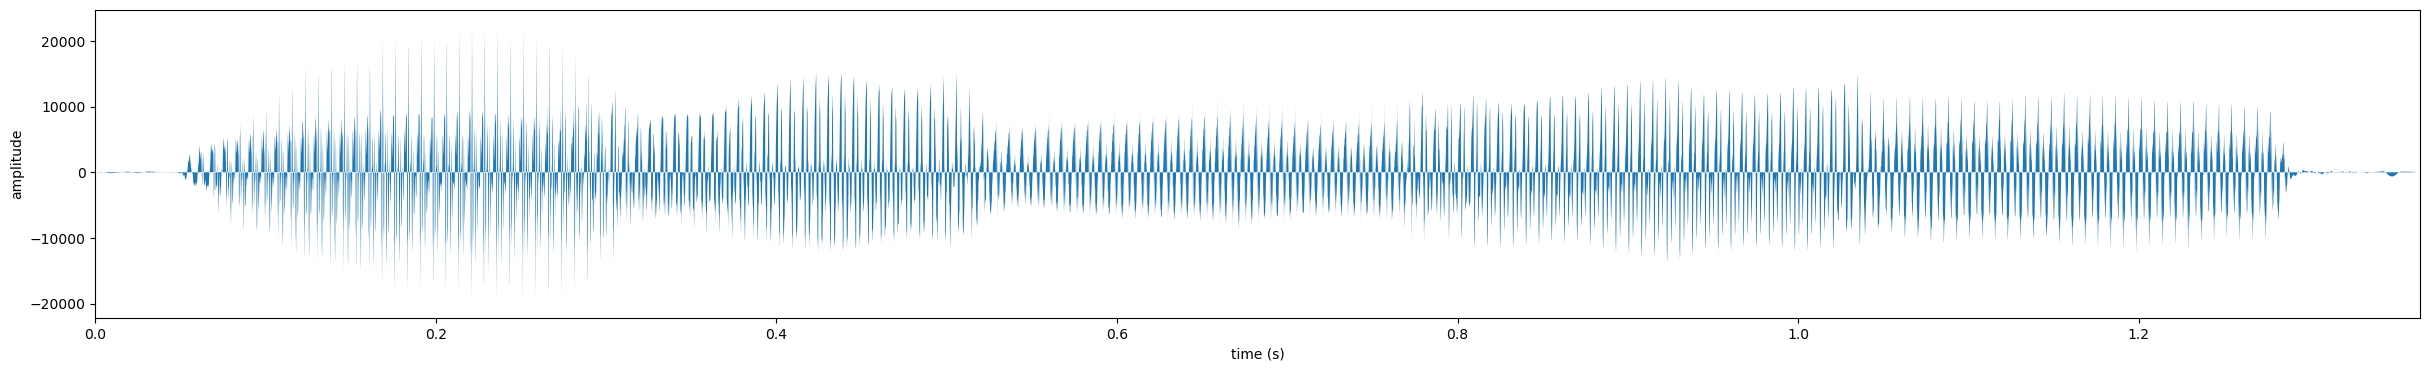

In [361]:
plot_sound(y, t)
write('new_aeiou.wav', Fs, np.array(y, dtype=np.int16))

In [362]:
IPython.display.Audio('new_aeiou.wav')

**Observation** :

The variation of the temporality is clear and audible. Though there is clearly no variation in terms of frequency (we hear the same pitch as before).

### 2.3 Modification of the spectral scale

In [363]:
def changePitchScale(beta, A, Fs):
    
    # Initialization of the variables
    t_s = np.array([1])
    n = np.array([0,1])
    P_a = A[2]
    voiced = A[1]
    scale = np.array([1])
    
    while int(n[-1]) < len(P_a):
        
        # If the signal is voiced, the scale is 1/beta
        if voiced[int(n[-1])]:
            scale = np.append(scale, 1/beta)
        else:
            scale = np.append(scale, 1)
            
        t_s = np.append(t_s, t_s[-1] + scale[-1] *P_a[int(n[-1])])
        n = np.append(n, n[-1] + scale[-1])
    
    return np.array([t_s, n[:-1]]).astype(int)

In [364]:
beta = 4

B = changePitchScale(beta, A, Fs)
y = synthesis(x, Fs, A, B)
t = np.arange(len(y)) * timestep

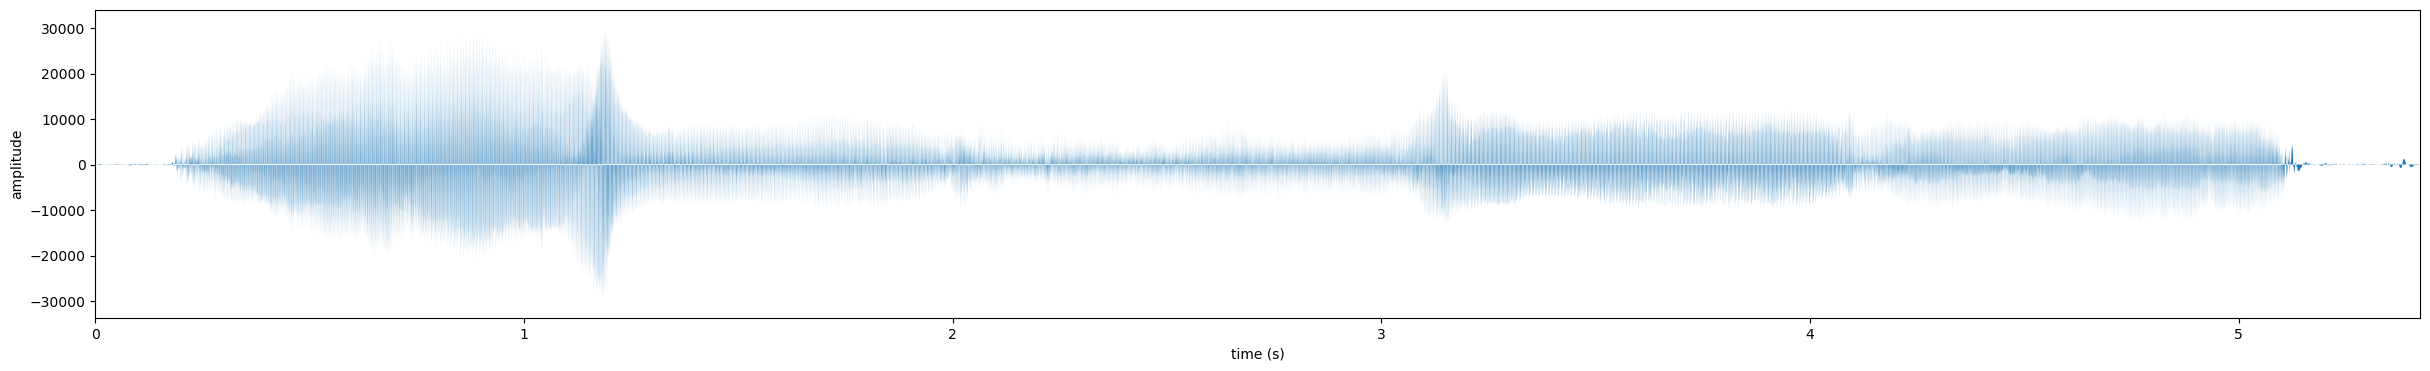

In [365]:
plot_sound(y, t)
write('new_aeiou.wav', Fs, np.array(y, dtype=np.int16))

In [366]:
IPython.display.Audio('new_aeiou.wav')

In [367]:
beta = 0.25

B = changePitchScale(beta, A, Fs)
y = synthesis(x, Fs, A, B)
t = np.arange(len(y)) * timestep

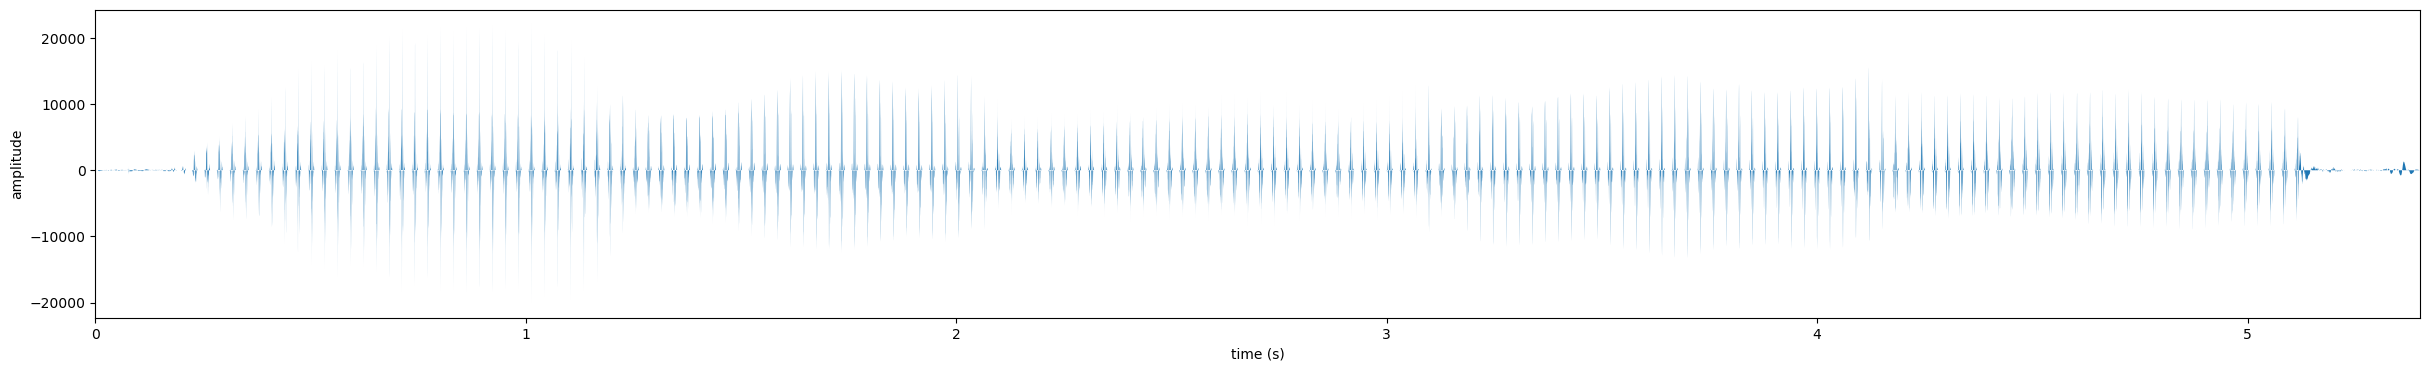

In [368]:
plot_sound(y, t)
write('new_aeiou.wav', Fs, np.array(y, dtype=np.int16))

In [369]:
IPython.display.Audio('new_aeiou.wav')

**Observation** :

This time, we clearly have the modification in the pitch (higher for the first one then lower). The PSOLA method works once again very well since we have no variation in terms of temporality.

### 2.4 Joint modification of the temporal and spectral scales

In [371]:
def changeBothScales(alpha, beta, A, Fs):
	t_s = np.array([1])
	n = np.array([0,1])
	P_a = A[2]
	voiced = A[1]
	scale = np.array([1])
	
	while int(n[-1]) < len(P_a):
		
		# If the signal is voiced, the scale is 1/beta
		if voiced[int(n[-1])]:
			scale = np.append(scale, 1/beta)
		else:
			scale = np.append(scale, 1)
		
		# We comibine the two scales, so they appear both only in n (no alpha in ts as we saw earlier)
		t_s = np.append(t_s, t_s[-1] + scale[-1] *P_a[int(n[-1])])
		n = np.append(n, n[-1] + scale[-1]/alpha)
	
	return np.array([t_s, n[:-1]]).astype(int)
    

In [372]:
alpha = 1.5
beta = 1.5

B = changeBothScales(alpha, beta, A, Fs)
y = synthesis(x, Fs, A, B)
t = np.arange(len(y)) * timestep

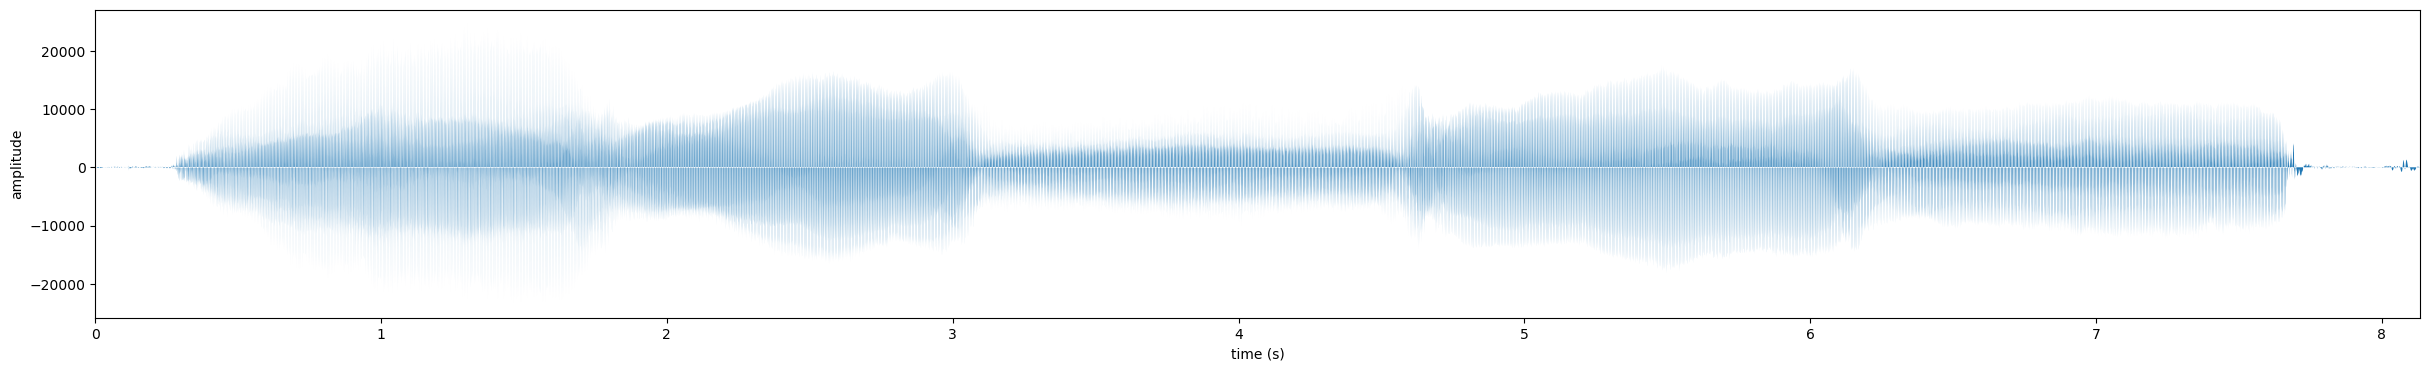

In [373]:
plot_sound(y, t)
write('new_aeiou.wav', Fs, np.array(y, dtype=np.int16))

In [374]:
IPython.display.Audio('new_aeiou.wav')	

In [375]:
alpha = .5
beta = .5

B = changeBothScales(alpha, beta, A, Fs)
y = synthesis(x, Fs, A, B)
t = np.arange(len(y)) * timestep

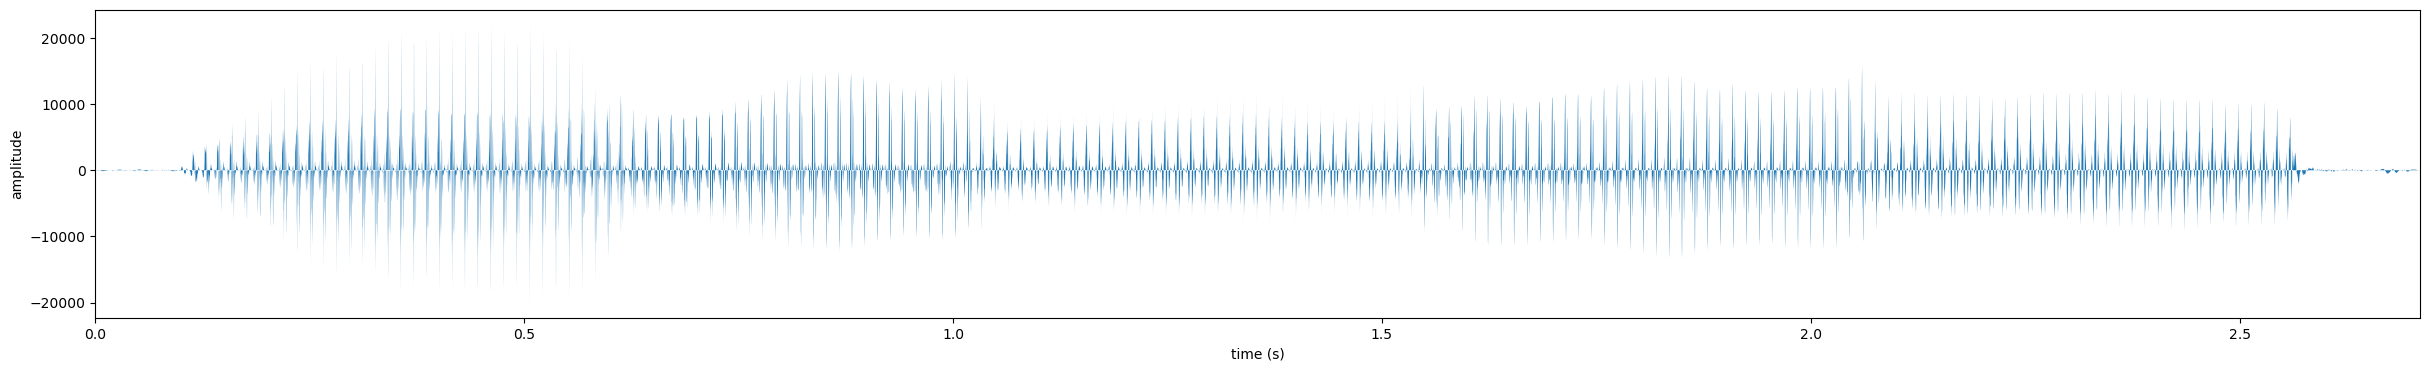

In [376]:
plot_sound(y, t)
write('new_aeiou.wav', Fs, np.array(y, dtype=np.int16))

In [377]:
IPython.display.Audio('new_aeiou.wav')	

In [378]:
alpha = 2
beta = 50

B = changeBothScales(alpha, beta, A, Fs)
y = synthesis(x, Fs, A, B)
t = np.arange(len(y)) * timestep

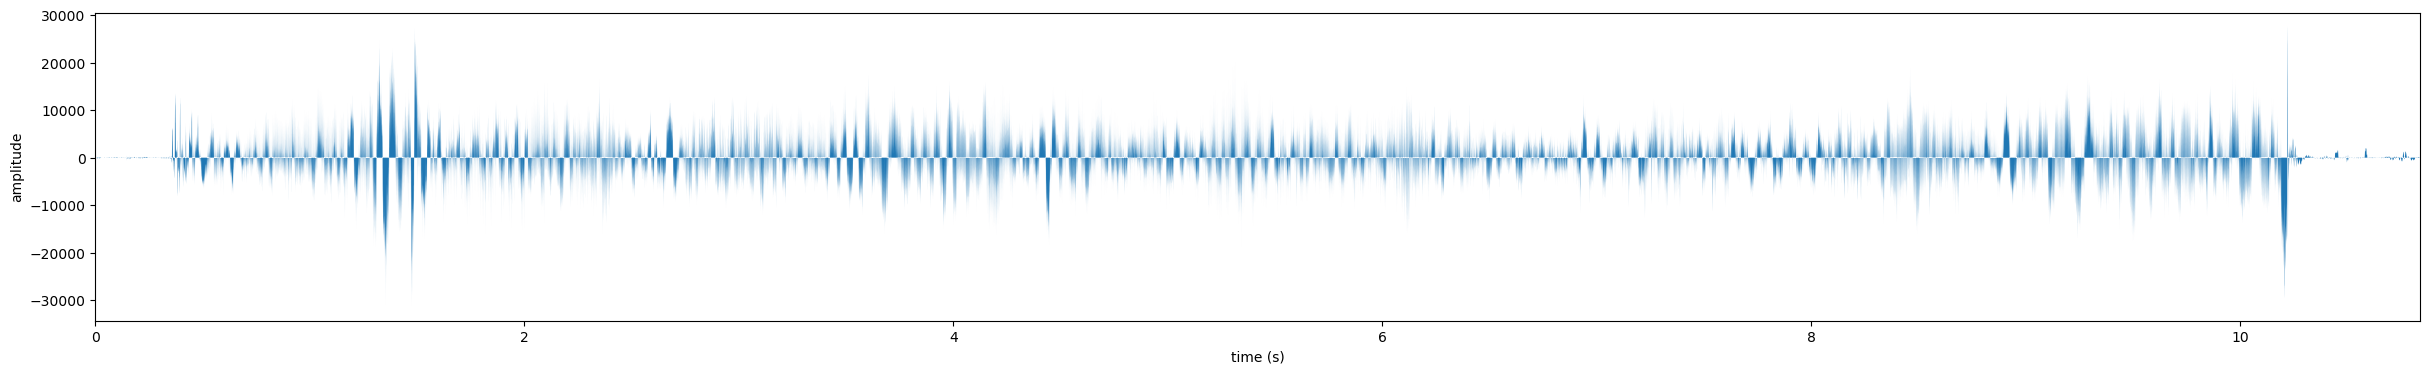

In [379]:
plot_sound(y, t)
write('new_aeiou.wav', Fs, np.array(y, dtype=np.int16))

In [380]:
IPython.display.Audio('new_aeiou.wav')	

**Observation** :

As we expected, the combination works well and allows us to control both the pitch and the tempo of the sound with different scales.